In [1]:
import tskit
import msprime
import stdpopsim
import networkx as nx
import matplotlib.pyplot as plt
import io
from IPython.display import display as SVG
import sys
import tszip

C:\Users\Philip\miniconda3\envs\Masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\Philip\miniconda3\envs\Masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [2]:
#visualize pedigrees
def draw_pedigree(ped_ts):
    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()


In [3]:
#given msprime functionality
pb = msprime.PedigreeBuilder()
mom_id = pb.add_individual(time=1)
dad_id = pb.add_individual(time=1)
pb.add_individual(time=0, parents=[mom_id, dad_id], is_sample=True)
pedigree = pb.finalise(sequence_length = 100)
 #TODO replace with display(pedigree) when its implemented in tskit
 #https://github.com/tskit-dev/tskit/issues/2093
print(pedigree)

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤════════╗
║id│flags│location│parents│metadata║
╠══╪═════╪════════╪═══════╪════════╣
║0 │    0│        │ -1, -1│        ║
║1 │    0│        │ -1, -1│        ║
║2 │    0│        │   0, 1│        ║
╚══╧═════╧════════╧═══════╧════════╝

Nodes
╔══╤═════╤══════════╤══════════╤════╤════════╗
║id│flags│population│individual│time│metadata║
╠══╪═════╪══════════╪══════════╪════╪════════╣
║0 │    0│         0│         0│   1│        ║
║1 │    0│         0│         0│   1│        ║
║2 │    0│         0│         1│   1│        ║
║3 │    0│         0│         1│   1│        ║
║4 │    1│         0│         2│   0│        ║
║5 │    1│         0│         2│   0│        ║
╚══╧═════╧══════════╧══════════╧════╧════════╝

Edges
╔══╤════╤═════╤══════╤═════╤════════╗
║id│left│right│parent│child│metadata║
╠══╪════╪═════╪══════╪═════╪════════╣
╚══╧════╧═════╧══════╧═════╧════════╝

Sites
╔══╤═══

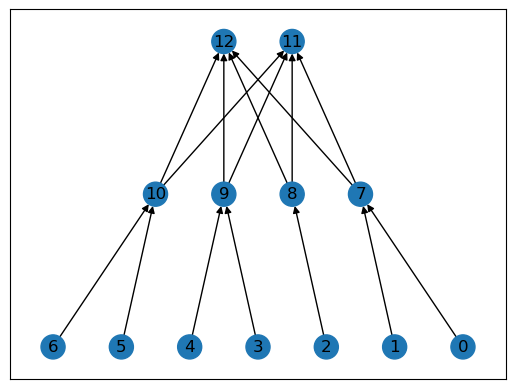

In [4]:
#example pedigrees
#id doesnt matter except for parent child relationships
ped_txt = """\
# id parent0 parent1 time
0 7 7 0.0
1 7 7 0.0
2 8 8 0.0
3 9 9 0.0
4 9 9 0.0
5 10 10 0.0
6 10 10 0.0
7 11 12 1.0
8 11 12 1.0
9 11 12 1.0
10 11 12 1.0
11 . . 2.0
12 . . 2.0
"""

pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length = 100)

draw_pedigree(pedigree.tree_sequence())

In [5]:
pedigree.tree_sequence()

In [6]:
#empty without ancestry and mutations
print(pedigree.tree_sequence().draw_text(y_axis=True, y_ticks=[0, 1, 2, 3, 4, 5]))

2.00┊                                 ┊ 
    ┊                                 ┊ 
1.00┊                                 ┊ 
    ┊                                 ┊ 
0.00┊ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ┊ 
    0                                100



In [7]:
#add ancestry simulations
ped_ts = msprime.sim_ancestry(
    initial_state=pedigree, model="fixed_pedigree", random_seed=41, recombination_rate = 0.001)

In [8]:
ped_ts = msprime.sim_mutations(ped_ts, rate = 0.001, random_seed = 42)

In [9]:
ped_ts.dump_tables().tree_sequence()

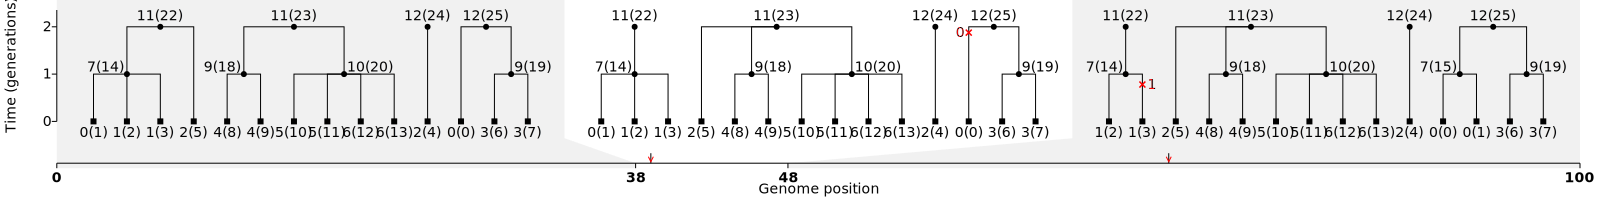

In [10]:
#print ancestry
node_labels = {node.id: f"{node.individual}({node.id})" for node in ped_ts.nodes()}
#SVG(ped_ts.draw_svg(y_axis=True,  node_labels=node_labels, size=(1600,200)))

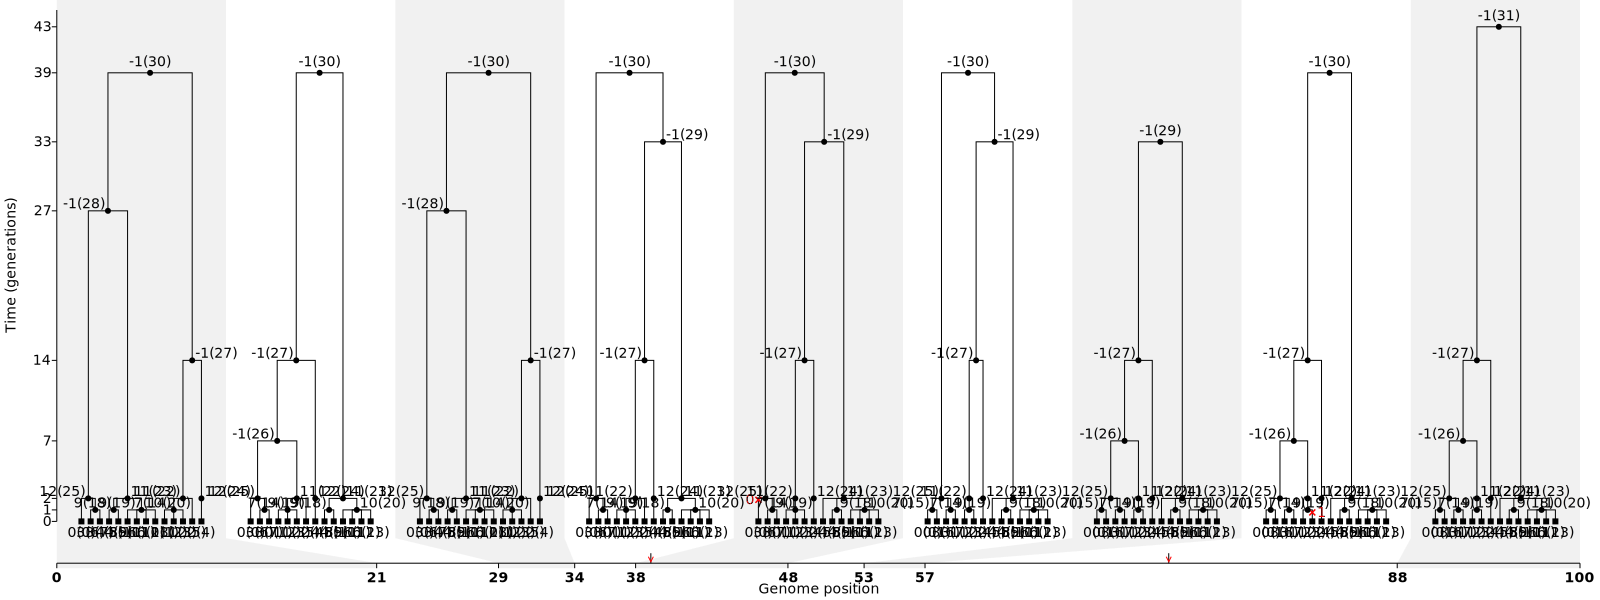

In [20]:
ped_ts2 = msprime.sim_ancestry(initial_state = ped_ts, model = "dtwf", recombination_rate= 0.001, population_size = 13, random_seed = 42)
node_labels = {node.id: f"{node.individual}({node.id})" for node in ped_ts2.nodes()}
#SVG(ped_ts2.draw_svg(y_axis = True, node_labels = node_labels, size = (1600,600)))

In [21]:
ped_ts2.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,0,1.87710543,T,-1,
1,1,3,0.77969100,G,-1,


In [22]:
#statistics
ped_ts.diversity(mode = "branch")

3.769670329670329

In [23]:
ped_ts.sites()[1]

Site(id=1, position=73.0, ancestral_state='A', mutations=[Mutation(id=1, site=1, node=3, derived_state='G', parent=-1, metadata=b'', time=0.7796909974422306, edge=2)], metadata=b'')

In [24]:
[ped_ts.sites()[x] for x in range(0,len(ped_ts.sites()))]

[Site(id=0, position=39.0, ancestral_state='A', mutations=[Mutation(id=0, site=0, node=0, derived_state='T', parent=-1, metadata=b'', time=1.8771054283715785, edge=19)], metadata=b''),
 Site(id=1, position=73.0, ancestral_state='A', mutations=[Mutation(id=1, site=1, node=3, derived_state='G', parent=-1, metadata=b'', time=0.7796909974422306, edge=2)], metadata=b'')]

In [26]:
ped_ts2.breakpoints(as_array = True)

array([  0.,  21.,  29.,  34.,  38.,  48.,  53.,  57.,  88., 100.])

In [17]:
#export ts
ped_ts.write_vcf(sys.stdout)

##fileformat=VCFv4.2
##source=tskit 0.5.5
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=100>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1	tsk_2	tsk_3	tsk_4	tsk_5	tsk_6
1	39	0	A	T	.	PASS	.	GT	1|0	0|0	0|0	0|0	0|0	0|0	0|0
1	73	1	A	G	.	PASS	.	GT	0|0	0|1	0|0	0|0	0|0	0|0	0|0


In [137]:
segments = ped_ts.ibd_segments(store_pairs = True, store_segments = True)
for pair, value in segments.items():
    print(pair, "::", value)
print(segments)

(0, 1) :: IdentitySegmentList(num_segments=1, total_span=52.0)
(0, 6) :: IdentitySegmentList(num_segments=2, total_span=100.0)
(0, 7) :: IdentitySegmentList(num_segments=2, total_span=100.0)
(1, 2) :: IdentitySegmentList(num_segments=1, total_span=48.0)
(1, 3) :: IdentitySegmentList(num_segments=1, total_span=48.0)
(1, 5) :: IdentitySegmentList(num_segments=1, total_span=38.0)
(1, 6) :: IdentitySegmentList(num_segments=1, total_span=52.0)
(1, 7) :: IdentitySegmentList(num_segments=1, total_span=52.0)
(2, 3) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(2, 5) :: IdentitySegmentList(num_segments=1, total_span=38.0)
(3, 5) :: IdentitySegmentList(num_segments=1, total_span=38.0)
(5, 8) :: IdentitySegmentList(num_segments=1, total_span=62.0)
(5, 9) :: IdentitySegmentList(num_segments=1, total_span=62.0)
(5, 10) :: IdentitySegmentList(num_segments=1, total_span=62.0)
(5, 11) :: IdentitySegmentList(num_segments=1, total_span=62.0)
(5, 12) :: IdentitySegmentList(num_segments=1, tot

In [21]:
#load simulated chrom 21 from Trocmé et al on genes quebec
#ts = tszip.decompress("simulated_chrom_21.ts.tsz")

In [25]:
#not enough memory on laptop
#print(ts.draw_text())

MemoryError: 